# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Spectrum

/content/drive/MyDrive/Spectrum


# Import Library

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, losses, metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Helper Function

In [ ]:
def training_curve(hist, is_acc):
    history = hist.history
    fig, loss_ax = plt.subplots(figsize=(10, 6))
    loss_ax.plot(history['loss'], label='train loss')
    loss_ax.plot(history['val_loss'], label='val loss')
    if is_acc:
        loss_ax.plot(history['acc'], label='train acc')
        loss_ax.plot(history['val_acc'], label='val acc')
        loss_ax.plot(history['binary_accuracy'], label='train binacc')
        loss_ax.plot(history['val_binary_accuracy'], label='val binacc')
    loss_ax.set_xlabel('epoch')
    loss_ax.legend(loc='upper left')
    plt.show()

In [ ]:
def acc(y_true, y_pred):
    compare = K.all(K.equal(y_true, K.round(y_pred)), axis=1)
    return K.mean(K.cast(compare, dtype='float32'))

# Load Data

## Preprocess Data

In [ ]:
ir = pd.read_csv('data/ir.csv', index_col='Unnamed: 0').T
ir.reset_index(inplace = True)
interpolate_args = { "method" : "linear", "order" : 1 }
ir.iloc[:, 1:] = ir.iloc[:, 1:].interpolate(**interpolate_args, limit_direction='both', axis = 0)
ir.set_index('index', inplace = True)
ir = ir.div(ir.max(axis=0), axis=1)

ms = pd.read_csv('data/mass.csv', index_col='Unnamed: 0').T.fillna(0)
ms = ms.loc[:,ms.sum(axis=0)!=0]
ms = ms.div(ms.max(axis=0), axis=1)

target = pd.read_csv('data/target.csv', index_col='cas')

In [ ]:
irms = pd.concat([ir, ms], axis=1, join='inner')
irms.index = irms.index.astype('int64')
df = pd.concat([irms, target], axis=1, join='inner')
df

,"(399.0, 402.25]","(402.25, 405.5]","(405.5, 408.75]","(408.75, 412.0]","(412.0, 415.25]","(415.25, 418.5]","(418.5, 421.75]","(421.75, 425.0]","(425.0, 428.25]","(428.25, 431.5]","(431.5, 434.75]","(434.75, 438.0]","(438.0, 441.25]","(441.25, 444.5]","(444.5, 447.75]","(447.75, 451.0]","(451.0, 454.25]","(454.25, 457.5]","(457.5, 460.75]","(460.75, 464.0]","(464.0, 467.25]","(467.25, 470.5]","(470.5, 473.75]","(473.75, 477.0]","(477.0, 480.25]","(480.25, 483.5]","(483.5, 486.75]","(486.75, 490.0]","(490.0, 493.25]","(493.25, 496.5]","(496.5, 499.75]","(499.75, 503.0]","(503.0, 506.25]","(506.25, 509.5]","(509.5, 512.75]","(512.75, 516.0]","(516.0, 519.25]","(519.25, 522.5]","(522.5, 525.75]","(525.75, 529.0]",...,"(627.0, 628.0]","(628.0, 629.0]","(629.0, 630.0]","(630.0, 631.0]","(631.0, 632.0]","(632.0, 633.0]","(633.0, 634.0]","(634.0, 635.0]","(635.0, 636.0]","(636.0, 637.0]","(637.0, 638.0]","(638.0, 639.0]","(639.0, 640.0]","(640.0, 641.0]","(641.0, 642.0]","(642.0, 643.0]","(643.0, 644.0]","(644.0, 645.0]","(645.0, 646.0]","(646.0, 647.0]","(647.0, 648.0]","(648.0, 649.0]","(649.0, 650.0]",alkane,methyl,alkene,alkyne,alcohols,amines,nitriles,aromatics,alkyl halides,esters,ketones,aldehydes,carboxylic acids,ether,acyl halides,amides,nitro
100005,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.068291,1.0,0.154513,0.134339,0.081143,1.0,0.085134,0.080863,0.094919,1.0,0.101019,0.110345,1.0,0.121615,0.054085,0.045658,0.024471,0.064017,0.055822,0.072083,0.062335,0.085047,0.163943,0.222675,0.061654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
100016,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.070188,1.0,0.146771,0.126694,0.081871,1.0,0.083557,0.078024,0.092230,1.0,0.097013,0.105651,1.0,0.116624,0.052338,0.045560,0.024471,0.063710,0.053609,0.068316,0.062335,0.079467,0.151175,0.204275,0.061654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
100027,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.072085,1.0,0.139029,0.119049,0.082599,1.0,0.081979,0.075184,0.089542,1.0,0.093007,0.100957,1.0,0.111633,0.050591,0.045462,0.024471,0.063404,0.051397,0.064549,0.062335,0.073886,0.138407,0.185876,0.061654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
100061,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.073982,1.0,0.131287,0.111404,0.083326,1.0,0.080401,0.072345,0.086854,1.0,0.089001,0.096264,1.0,0.106641,0.048844,0.045363,0.024471,0.063098,0.049185,0.060781,0.062335,0.068306,0.125638,0.167476,0.061654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1000868,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.075879,1.0,0.123545,0.103759,0.084054,1.0,0.078824,0.069505,0.084165,1.0,0.084995,0.091570,1.0,0.101650,0.047096,0.045265,0.024471,0.062792,0.046972,0.057014,0.062335,0.062726,0.112870,0.149076,0.061654,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999644,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.024550,1.0,0.033124,0.015857,0.050736,1.0,0.035466,0.031234,0.050931,1.0,0.066219,0.077052,1.0,0.147260,0.093777,0.132431,0.012993,0.131928,0.072372,0.041199,0.007911,0.024489,0.018990,0.015096,0.004266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,0,0,0,0,0,1,0,0,0,0,

## Split Data

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df[irms.columns], df[target.columns], test_size=0.2, random_state=7)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=77)

In [ ]:
AE_train = irms.drop(X_test.index).drop(X_valid.index)
AE_valid = irms.loc[X_valid.index]
AE_test = irms.loc[X_test.index]

# Train AE+MLP Model

## Train AutoEncoder

In [ ]:
inputlayer = layers.Input(shape=irms.shape[1])
encoded = layers.Dense(256, activation='relu')(inputlayer)
decoded = layers.Dense(irms.shape[1], activation='sigmoid')(encoded)

In [ ]:
encoder = models.Model(inputlayer, encoded)
autoencoder = models.Model(inputlayer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1757)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               450048    
_________________________________________________________________
dense_1 (Dense)              (None, 1757)              451549    
Total params: 901,597
Trainable params: 901,597
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mc = ModelCheckpoint('AutoEncoder.h5', monitor='val_loss', mode='min', save_best_only=True)
hist = autoencoder.fit(AE_train, AE_train, epochs=500, validation_data=(AE_valid, AE_valid), batch_size=64, callbacks=[mc])

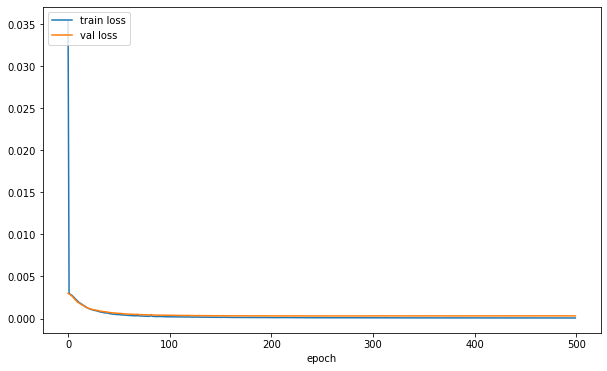

In [ ]:
training_curve(hist, False)

## Load AutoEncoder

In [ ]:
autoencoder = models.load_model('AutoEncoder.h5')
encoder = models.Model(autoencoder.layers[0].input, autoencoder.layers[1].output)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1757)]            0         
_________________________________________________________________
dense (Dense)                (None, 256)               450048    
Total params: 450,048
Trainable params: 450,048
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pred = autoencoder.predict(AE_test)
print(f"MAE : {mean_absolute_error(AE_test, pred)}")
print(f"MSE : {mean_squared_error(AE_test, pred)}")

MAE : 0.00598124321390374
MSE : 0.00030631751549475833


## Train MLP Model

In [ ]:
inputlayer = layers.Input(shape=256)
hiddenlayer = layers.Dense(200)(inputlayer)
hiddenlayer = layers.BatchNormalization()(hiddenlayer)
hiddenlayer = layers.ReLU()(hiddenlayer)
hiddenlayer = layers.Dropout(0.45)(hiddenlayer)
hiddenlayer = layers.Dense(150)(hiddenlayer)
hiddenlayer = layers.BatchNormalization()(hiddenlayer)
hiddenlayer = layers.ReLU()(hiddenlayer)
hiddenlayer = layers.Dropout(0.15)(hiddenlayer)
outputlayer = layers.Dense(target.shape[1], activation='sigmoid')(hiddenlayer)

In [ ]:
model = models.Model(inputlayer, outputlayer)
model.compile(optimizer=Adam(learning_rate=0.00015), loss=losses.BinaryCrossentropy(), metrics=[acc, metrics.BinaryAccuracy()])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               51400     
_________________________________________________________________
batch_normalization_4 (Batch (None, 200)               800       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 200)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 150)               30150     
_________________________________________________________________
batch_normalization_5 (Batch (None, 150)               600 

In [ ]:
mc = ModelCheckpoint('Multi Layer Perceptron.h5', monitor='val_loss', mode='min', save_best_only=True)
hist = model.fit(encoder.predict(X_train), Y_train, epochs=500, batch_size=64, validation_data=(encoder.predict(X_valid), Y_valid), callbacks=[mc])

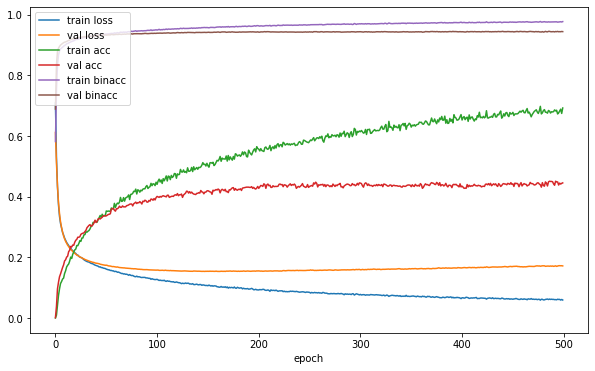

In [ ]:
training_curve(hist, True)

In [ ]:
model = models.load_model('Multi Layer Perceptron.h5')
pred = model.predict(encoder.predict(X_test)) > 0.5
print(f"Accuracy : {accuracy_score(Y_test, pred)}")
Y_test_flatten = Y_test.to_numpy().reshape(-1)
pred_flatten = pred.reshape(-1)
print(f"Binary Accuracy : {accuracy_score(Y_test_flatten, pred_flatten)}")
print(f"Balanced Binary Accuracy : {balanced_accuracy_score(Y_test_flatten, pred_flatten)}")
print(f"F1 score : {f1_score(Y_test_flatten, pred_flatten)}")
print("Confusion Matrix : ")
print(confusion_matrix(Y_test_flatten, pred_flatten))

Accuracy : 0.4552580013063357
Binary Accuracy : 0.9439812502401352
Balanced Binary Accuracy : 0.9020460702945899
F1 score : 0.8549253731343284
Confusion Matrix : 
[[20273   594]
 [  864  4296]]


# Train CNN Model

In [ ]:
def get_Conv_Pool(n, layer, w_f=3, w_p=2):
    layer = layers.Conv1D(n, w_f)(layer)
    layer = layers.ELU()(layer)
    layer = layers.MaxPooling1D(w_p)(layer)
    return layer

In [ ]:
def get_Dense(n, p, layer):
    layer = layers.Dense(n)(layer)
    layer = layers.BatchNormalization()(layer)
    layer = layers.ELU()(layer)
    layer = layers.Dropout(p)(layer)
    return layer

In [ ]:
inputlayer = layers.Input(shape=(irms.shape[1], 1))
hiddenlayer = get_Conv_Pool(4, inputlayer)
hiddenlayer = get_Conv_Pool(4, hiddenlayer)
hiddenlayer = get_Conv_Pool(8, hiddenlayer)
hiddenlayer = get_Conv_Pool(8, hiddenlayer)
hiddenlayer = get_Conv_Pool(16, hiddenlayer)
hiddenlayer = get_Conv_Pool(16, hiddenlayer)
hiddenlayer = layers.Flatten()(hiddenlayer)
hiddenlayer = get_Dense(128, 0.4, hiddenlayer)
hiddenlayer = get_Dense(128, 0.2, hiddenlayer)
outputlayer = layers.Dense(target.shape[1], activation='sigmoid')(hiddenlayer)

In [ ]:
model = models.Model(inputlayer, outputlayer)
model.compile(optimizer=Adam(learning_rate=1e-3), loss=losses.BinaryCrossentropy(), metrics=[acc, metrics.BinaryAccuracy()])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1757, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1755, 4)           16        
_________________________________________________________________
elu (ELU)                    (None, 1755, 4)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 877, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 875, 4)            52        
_________________________________________________________________
elu_1 (ELU)                  (None, 875, 4)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 437, 4)            0   

In [ ]:
mc = ModelCheckpoint('1D CNN.h5', monitor='val_loss', mode='min', save_best_only=True)
hist = model.fit(np.expand_dims(X_train, axis=-1), Y_train, epochs=200, batch_size=64, validation_data=(X_valid, Y_valid), callbacks=[mc])

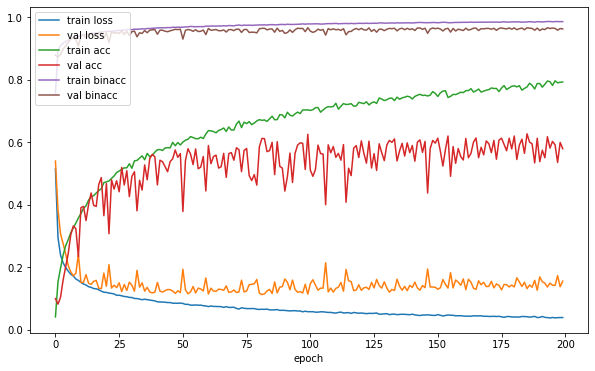

In [ ]:
training_curve(hist, True)

In [ ]:
model = models.load_model('1D CNN.h5')
pred = model.predict(np.expand_dims(X_test, axis=-1)) > 0.5
print(f"Accuracy : {accuracy_score(Y_test, pred)}")
Y_test_flatten = Y_test.to_numpy().reshape(-1)
pred_flatten = pred.reshape(-1)
print(f"Binary Accuracy : {accuracy_score(Y_test_flatten, pred_flatten)}")
print(f"Balanced Binary Accuracy : {balanced_accuracy_score(Y_test_flatten, pred_flatten)}")
print(f"F1 score : {f1_score(Y_test_flatten, pred_flatten)}")
print("Confusion Matrix : ")
print(confusion_matrix(Y_test_flatten, pred_flatten))

Accuracy : 0.5924232527759634
Binary Accuracy : 0.9625389019095555
Balanced Binary Accuracy : 0.9381265177798259
F1 score : 0.9047758570172868
Confusion Matrix : 
[[20420   447]
 [  528  4632]]
